In [1]:
from __future__ import division
%pylab inline
import numpy as np
import scipy.spatial.distance as dist
from scipy import stats
import pickle
import math
import collections
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
# " " = high   =  1
# "%" = low    =  0
# len(row) = 10
def countNum(name = "yes_train.txt"):
    with open(name) as dataset:
        num_lines = sum(1 for line in dataset)
        return num_lines / 28
    


for training 

In [3]:
# label yes = 1
# label no = 0
Num_sample_yes =  countNum()
Num_sample_no =  countNum("no_train.txt")
print(Num_sample_yes,Num_sample_no)

(140.0, 131.0)


In [4]:
Num_test_yes =  countNum("yes_test.txt")
Num_test_no =  countNum("no_test.txt")
print(Num_test_yes,Num_test_no)

(50.0, 50.0)


In [5]:
def inputDigit(name="yes_train.txt"):
    with open(name) as digitTxt:
        image = [list(line)[0:10] for line in digitTxt]
    return image

In [6]:
data_yes = inputDigit()
data_no = inputDigit("no_train.txt")
test_yes = inputDigit("yes_test.txt")
test_no = inputDigit("no_test.txt")

In [7]:
#   yes is class 0
#   no is class 1
# k = 0
    
def training(yes_train, no_train, yes_num, no_num,k):
    # " " = high   =  1
    # "%" = low    =  0
    
    class_total = [yes_num, no_num]

    training0 = np.zeros(shape=(2, 25, 10))   #high
    training1 = np.zeros(shape=(2, 25, 10))   #low
    
    temp_training0 = np.zeros(shape=(2, 25)) 
    temp_training1 = np.zeros(shape=(2, 25))   
    

    count = 0
    for i in range(int(yes_num)):
        for row in range(25):
            for col in range(10):
                if yes_train[i*28 + row][col] == ' ':      # offset = i*28, since 25 + 3(blank rows)
                    training1[0][row][col] += 1
                else:
                    training0[0][row][col] += 1
    
    for row in range(25):
        temp_training1[0][row] = sum(training1[0][row]) / 10
        temp_training0[0][row] = sum(training0[0][row]) / 10
            
    for i in range(int(no_num)):
        for row in range(25):
            for col in range(10):
                if no_train[i*28 + row][col] == ' ':
                    training1[1][row][col] += 1
                else:
                    training0[1][row][col] += 1
    for row in range(25):
        temp_training1[1][row] = sum(training1[1][row]) / 10
        temp_training0[1][row] = sum(training0[1][row]) / 10
        
    # laplace smooth
#     print k
    for i in range(2):
        temp_training1[i] = (temp_training1[i] + k) / (class_total[i] + k * 2)
        
        temp_training0[i] = (temp_training0[i] + k) / (class_total[i] + k * 2)
#     print(temp_training0[1][0])
#     print(temp_training1[1][0])
#     print temp_training0.shape, temp_training1.shape
    return temp_training0, temp_training1


In [8]:
k = 1
temp_training0, temp_training1 = training(data_yes, data_no, Num_sample_yes, Num_sample_no,k)

In [9]:
# log P(class) + log P(f1,1 | class) + log P(f1,2 | class) + ... + log P(f28,28 | class)

# test_rough = inputDigit(name = "digitdata/testimages")
def testing(yes_test, no_test, Num_test_yes, Num_test_no):

    data_test = np.concatenate( (yes_test, no_test) , axis = 0 )
# #     print len(data_test) / 28
#     return 

    total = Num_test_yes + Num_test_no
    answer = np.zeros(int(total))
    
    class_total = [Num_test_yes, Num_test_no]
    
    for i in range(int(total)):
        test_image = np.zeros(shape=(25,10))
        temp_test_image = np.zeros(25)
        for row in range(25):
            for col in range(10):
                if data_test[i*28+row][col] == ' ':
                    test_image[row][col] = 1
                else:
                    test_image[row][col] = 0
                
            temp_test_image[row] = sum(test_image[row]) / 10
        
#         print temp_test_image[row]

        posteriori = np.zeros(2)
        for class_num in range(2):
            posteriori[class_num] = math.log(class_total[class_num])
            for row in range(25):
                if temp_test_image[row] == 0:
                    posteriori[class_num] += math.log(temp_training0[class_num][row])
                else:
                    posteriori[class_num] += math.log(temp_training1[class_num][row])   
        answer[i] = np.argmax(posteriori)

    return answer

In [10]:
answer = testing(test_yes, test_no, Num_test_yes, Num_test_no)

In [11]:
def confusion_matrix(pred):
    conf_matrix = np.zeros(shape=(2,2))
    #print(conf_matrix[0][0])
    #print(int(answer[0]))
    for i in range(100):
        if i < 50:
            conf_matrix[0][int(pred[i])] += 1
        else:
            conf_matrix[1][int(pred[i])] += 1
            
    for i in range(2):
        for j in range(2):
            conf_matrix[i][j] /= 50.0
    
    return conf_matrix

In [12]:
# print confusion matrix
conf_matrix = confusion_matrix(answer)
conf_matrix = np.around(conf_matrix, 2)
for row in conf_matrix:
    print(row)
overall_accuracy = 0
for i in range(2):
    overall_accuracy += conf_matrix[i][i] * 50.0
print("overall_accuracy = " + str(overall_accuracy/100))

[ 0.98  0.02]
[ 0.08  0.92]
overall_accuracy = 0.95


# Now, let's find the best k##

In [13]:
# Laplace smoothing constant
k1 = np.array([10**(-6), 10**(-5), 10**(-4), 0.001, 0.002, 0.005, 0.01, 0.02, 0.05])
k2 = np.linspace(0.1, 10, 100)
k_grid = np.append(k1, k2)

accuracy = np.zeros(109)

for k_index in range(109):
    k = k_grid[k_index]
    #print(k)
    training0, training1 = training(data_yes, data_no, Num_sample_yes, Num_sample_no,k)
    answer = testing(test_yes, test_no, Num_test_yes, Num_test_no)
    conf_matrix = confusion_matrix(answer)
    overall_accuracy = 0
    for i in range(2):
        overall_accuracy += conf_matrix[i][i] * 50.0
        accuracy[k_index] = overall_accuracy
    print("accuracy =", overall_accuracy/100.0, "when k is ", k_grid[k_index])

('accuracy =', 0.94999999999999996, 'when k is ', 9.9999999999999995e-07)
('accuracy =', 0.94999999999999996, 'when k is ', 1.0000000000000001e-05)
('accuracy =', 0.94999999999999996, 'when k is ', 0.0001)
('accuracy =', 0.94999999999999996, 'when k is ', 0.001)
('accuracy =', 0.94999999999999996, 'when k is ', 0.002)
('accuracy =', 0.94999999999999996, 'when k is ', 0.0050000000000000001)
('accuracy =', 0.94999999999999996, 'when k is ', 0.01)
('accuracy =', 0.94999999999999996, 'when k is ', 0.02)
('accuracy =', 0.94999999999999996, 'when k is ', 0.050000000000000003)
('accuracy =', 0.94999999999999996, 'when k is ', 0.10000000000000001)
('accuracy =', 0.94999999999999996, 'when k is ', 0.20000000000000001)
('accuracy =', 0.94999999999999996, 'when k is ', 0.30000000000000004)
('accuracy =', 0.94999999999999996, 'when k is ', 0.40000000000000002)
('accuracy =', 0.94999999999999996, 'when k is ', 0.5)
('accuracy =', 0.94999999999999996, 'when k is ', 0.59999999999999998)
('accuracy ='

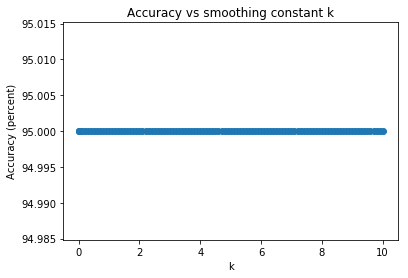

In [14]:
%matplotlib inline
plt.figure()
ax = plt.gca()
#ax.set_xscale('log')
plt.scatter(k_grid[5:], accuracy[5:], label = 'f(x)')
plt.xlabel("k")
plt.ylabel("Accuracy (percent)")
plt.title("Accuracy vs smoothing constant k")

In [15]:
# Laplace smoothing constant
k_grid = np.linspace(3.0, 3.6, 60)

accuracy = np.zeros(60)

for k_index in range(60):
    k = k_grid[k_index]
    #print(k)
    training0, training1 = training(data_yes, data_no, Num_sample_yes, Num_sample_no,k)
    answer = testing(test_yes, test_no, Num_test_yes, Num_test_no)
    conf_matrix = confusion_matrix(answer)
    overall_accuracy = 0
    for i in range(2):
        overall_accuracy += conf_matrix[i][i] * 50
        accuracy[k_index] = overall_accuracy
    print("accuracy =", overall_accuracy/100, "when k is ", k_grid[k_index])

('accuracy =', 0.94999999999999996, 'when k is ', 3.0)
('accuracy =', 0.94999999999999996, 'when k is ', 3.0101694915254238)
('accuracy =', 0.94999999999999996, 'when k is ', 3.0203389830508476)
('accuracy =', 0.94999999999999996, 'when k is ', 3.0305084745762714)
('accuracy =', 0.94999999999999996, 'when k is ', 3.0406779661016947)
('accuracy =', 0.94999999999999996, 'when k is ', 3.0508474576271185)
('accuracy =', 0.94999999999999996, 'when k is ', 3.0610169491525423)
('accuracy =', 0.94999999999999996, 'when k is ', 3.0711864406779661)
('accuracy =', 0.94999999999999996, 'when k is ', 3.0813559322033899)
('accuracy =', 0.94999999999999996, 'when k is ', 3.0915254237288137)
('accuracy =', 0.94999999999999996, 'when k is ', 3.1016949152542375)
('accuracy =', 0.94999999999999996, 'when k is ', 3.1118644067796613)
('accuracy =', 0.94999999999999996, 'when k is ', 3.1220338983050846)
('accuracy =', 0.94999999999999996, 'when k is ', 3.1322033898305084)
('accuracy =', 0.94999999999999996,